# Customers Segmentation using Keras

In [16]:
# General use libraries
import pandas as pd
import matplotlib.pyplot as plt 
import duckdb
import seaborn as sns

# Normality Test
from scipy.stats import shapiro

# To split into train and test
from sklearn.model_selection import train_test_split

# Keras cluster model
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout

In [2]:
# Importing dataset
df = pd.read_csv("data_customer_classification.csv")
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [3]:
# Normalicer function
def normalizer(column):
    """ Normalizer. Receives a column name and
        normalize the data in it
        
    Args:
        column (str): The name of the column to analyse

    Returns:
        True, indicating that the data was normalized
        and stored in the dataset
    """
    df_max_scaled = df.copy()
    df[column] = df_max_scaled[column] /df_max_scaled[column].abs().max()
    
    return True

## Exploration
- Search for NA values and not normal observations
- Searching for relevant information about the data

In [4]:
print(len(df))

125000


In [5]:
df.nunique(axis=0)

customer_id    6889
trans_date     1401
tran_amount      96
dtype: int64

There are 6889 unique customers from 125,000 observations, it is possible to make combinations for each customer

In [6]:
# % of NAs for each column. No NA's in the dataset
nas = pd.DataFrame(df.isna().sum()/df.shape[0], columns = ['%NAs']).reset_index()
nas

,index,%NAs
0,customer_id,0.0
1,trans_date,0.0
2,tran_amount,0.0


In [7]:
df.describe()

,tran_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


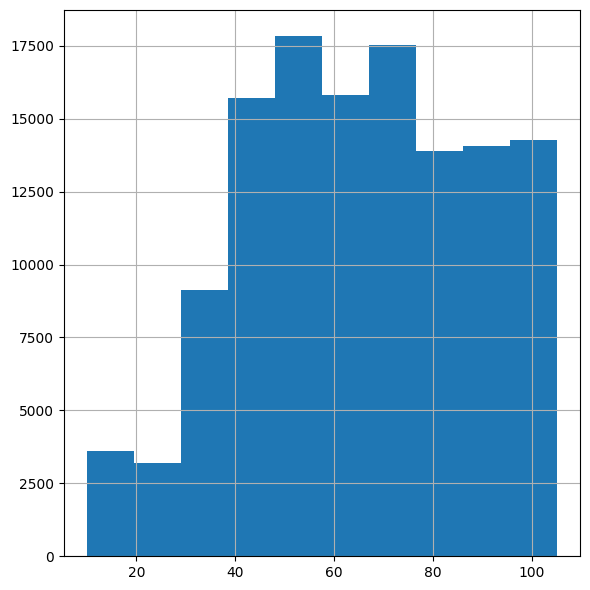

In [8]:
# Plotting the amounts of all the transactions
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 1)

df["tran_amount"].hist(figsize=(6,6))

plt.show()

In [9]:
# Normality test scores
stat, p = shapiro(df['tran_amount'])
print('Statistics=%.3f, p=%.5f' % (stat, p))

# Defining what we will do depending the result
alpha = 0.05
if p > alpha:
    print('Sample looks Gaussian (fail to reject H0)')
else:
    normalizer('tran_amount')
    print('ready')


Statistics=0.978, p=0.00000
ready


c:\Users\danie\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\stats\_morestats.py:1800: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [10]:
# Preparing important values to start using the model
transactions = duckdb.query('''SELECT customer_id, MAX(tran_amount) as max_trans, MIN(tran_amount) as min_trans, 
                            MEAN(tran_amount) as trans_mean, count(customer_id) as frequency, min(trans_date) as tran_min_date, 
                            max(trans_date) as tran_max_date
                            FROM df 
                            group by customer_id''').to_df()
transactions.head()

,customer_id,max_trans,min_trans,trans_mean,frequency,tran_min_date,tran_max_date
0,CS4372,0.809524,0.361905,0.601190,16,05-Sep-12,29-Apr-12
1,CS1790,0.952381,0.333333,0.656614,18,04-Dec-12,29-Dec-13
2,CS1475,1.000000,0.342857,0.633333,18,02-Mar-13,29-Jul-11
3,CS5155,0.952381,0.361905,0.673260,26,01-Apr-14,30-Jun-12
4,CS1582,1.000000,0.333333,0.708642,27,05-Dec-11,30-Sep-11


## Model usage

In [11]:
X_train_full, X_test = train_test_split(transactions, test_size=0.3, random_state=20)
X_train, X_valid = X_train_full[:-1000], X_train_full[-1000:]
X_train_full

,customer_id,max_trans,min_trans,trans_mean,frequency,tran_min_date,tran_max_date
4815,CS8900,0.733333,0.104762,0.397199,17,01-Feb-12,31-Jan-14
3976,CS1686,0.980952,0.342857,0.653571,24,01-Jan-14,30-May-12
6250,CS5585,0.952381,0.352381,0.582684,11,03-Jul-12,24-Sep-13
2731,CS2315,0.990476,0.333333,0.608333,16,05-May-12,29-May-13
4755,CS7785,0.742857,0.104762,0.434085,19,01-Jul-12,30-Jun-14
...,...,...,...,...,...,...,...
3915,CS2472,0.933333,0.333333,0.617043,19,02-Nov-14,29-May-11
1428,CS3217,1.000000,0.352381,0.754887,19,02-Nov-13,31-Dec-11
6537,CS3672,1.000000,0.342857,0.736190,20,01-Apr-14,29-May-11
4367,CS8672,0.733333,0.266667,0.506032,15,02-Jan-12,30-Sep-11


In [12]:
# Select relevant features for segmentation
X = X_train_full[['max_trans', 'min_trans', 'trans_mean', 'frequency']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Applying KMeans for segmentation
kmeans = KMeans(n_clusters=3)  # Define the number of clusters
kmeans.fit(X_scaled)
X_train_full['cluster'] = kmeans.labels_

# Creating a neural network for segmentation using Keras
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(3, activation='softmax'))
model.summary()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the clustered data
X_train = X_scaled
y_train = X_train_full['cluster']
model.fit(X_train, y_train, epochs=25, batch_size=32)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                 51        
                                                                 
Total params: 2,979
Trainable params: 2,979
Non-trainabl

In [13]:
X_train_full

,customer_id,max_trans,min_trans,trans_mean,frequency,tran_min_date,tran_max_date,cluster
4815,CS8900,0.733333,0.104762,0.397199,17,01-Feb-12,31-Jan-14,1
3976,CS1686,0.980952,0.342857,0.653571,24,01-Jan-14,30-May-12,2
6250,CS5585,0.952381,0.352381,0.582684,11,03-Jul-12,24-Sep-13,0
2731,CS2315,0.990476,0.333333,0.608333,16,05-May-12,29-May-13,0
4755,CS7785,0.742857,0.104762,0.434085,19,01-Jul-12,30-Jun-14,1
...,...,...,...,...,...,...,...,...
3915,CS2472,0.933333,0.333333,0.617043,19,02-Nov-14,29-May-11,0
1428,CS3217,1.000000,0.352381,0.754887,19,02-Nov-13,31-Dec-11,0
6537,CS3672,1.000000,0.342857,0.736190,20,01-Apr-14,29-May-11,0
4367,CS8672,0.733333,0.266667,0.506032,15,02-Jan-12,30-Sep-11,1


## Results evaluation

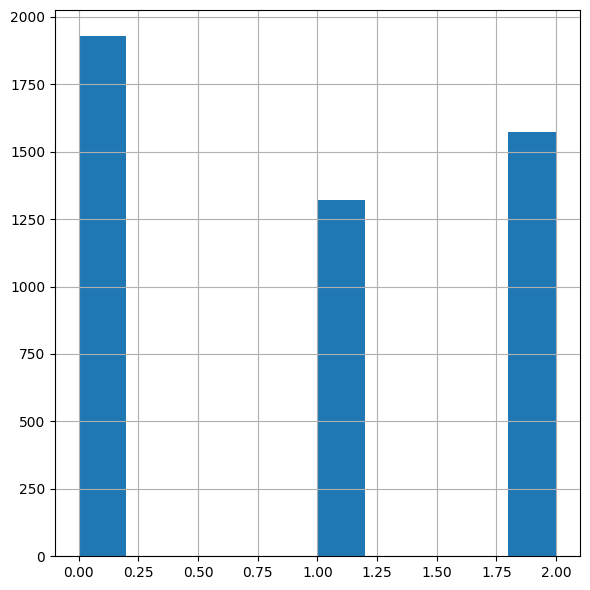

In [15]:
# Plotting the results
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True

fig, axes = plt.subplots(1, 1)

X_train_full["cluster"].hist(figsize=(6,6))

plt.show()

<Figure size 2000x600 with 0 Axes>

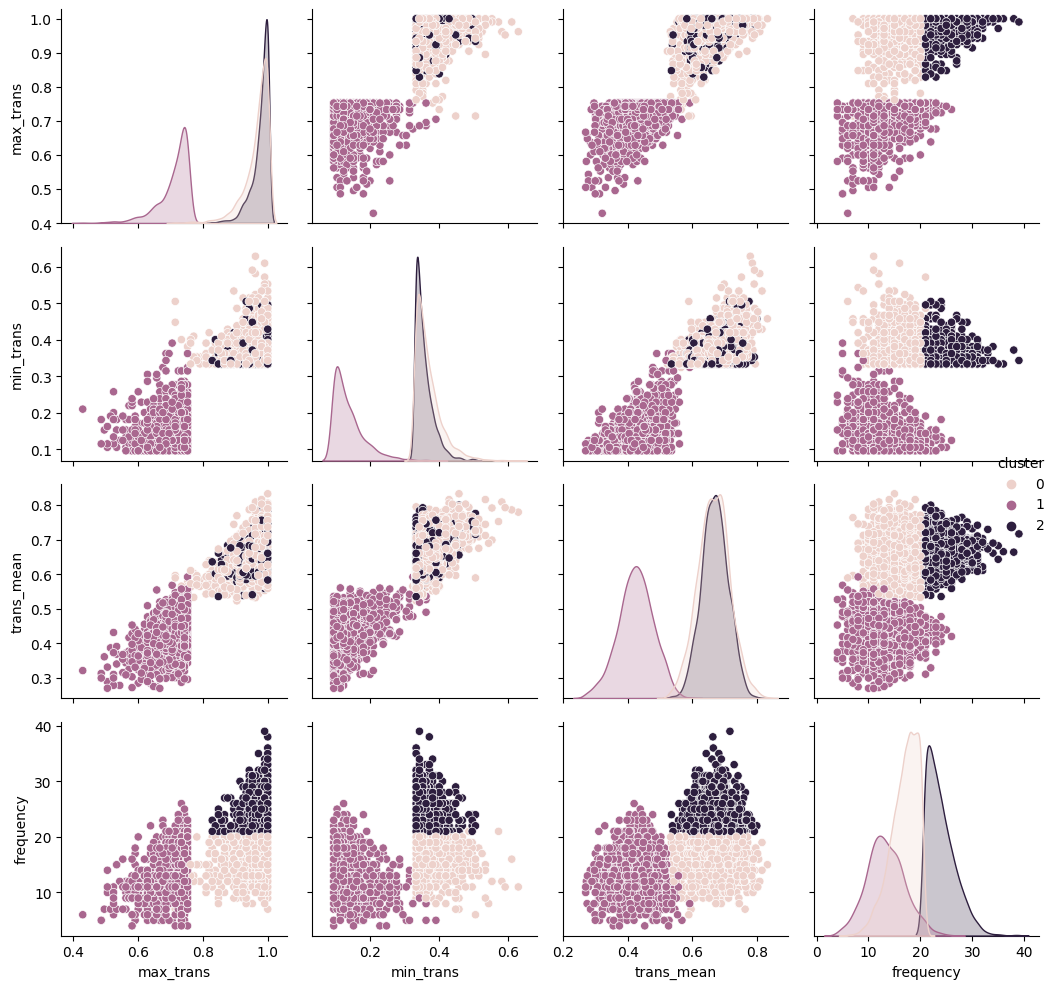

In [17]:
plt.figure(figsize=(20,6))
sns.pairplot(data=X_train_full, diag_kind='kde', hue='cluster')
plt.show()

## Conclusions:
- The Keras model identified this three groups:
    - Group 0 is a medium client because their transactions are high or close to the mean but they are not frequent
    - Group 1 is a low client because their purchases are small and they don't go to buy a lot
    - Group 2 is a high client because they are clients that go frequently and trend to buy more in comparison to other groups
- The dates could be used to identify temporal moments in which the store receives more clients

## Observations:
- The habits could not be tracked because the information about what they frequently buy is not available and could be benefitial to have it
- Income information or demographics could give a better segmentation of the customers and help the store to reduce payment risks like unpayed credits